In [1]:
# Standard Imports
import sys
import warnings
sys.path.append("scripts")
warnings.filterwarnings("ignore")

# Relative Imports
from scripts import *

The input sound is initially binaural, keeping both channels to be able to play it

In [2]:
file_name = "H dur rychle.wav"
base_name, extension = file_name.split(".")
sound = load_sound(file_name, monaural=False)

Loaded sound "..\data\wav\H dur rychle.wav"
Duration: 8.27733333 s, samples: 397312, samplerate: 48. kHz


If Pygame is installed, you can uncomment the line below to play the input sound
WARNING! The sound may be very loud

In [3]:
# sound.play(sleep=True)

For the rest of the implementation, monaural sound is needed. Using only the left channel

In [4]:
sound = sound.left

Add white noise

In [5]:
noise_level = 0.01
sound = add_white_noise(sound, noise_level)
save_sound(sound, base_name + " Noised." + extension)

If Pygame is installed, you can uncomment the line below to play the noised sound
WARNING! The sound may be very loud

In [6]:
# sound.play(sleep=True)

Cochleagram

In [7]:
n_channels = 128
cochleagram, center_freqs = compute_cochleagram(sound, n_channels, return_cf=True)
print(f"Cochleagram shape: {cochleagram.shape}")

Cochleagram shape: (128, 397312)


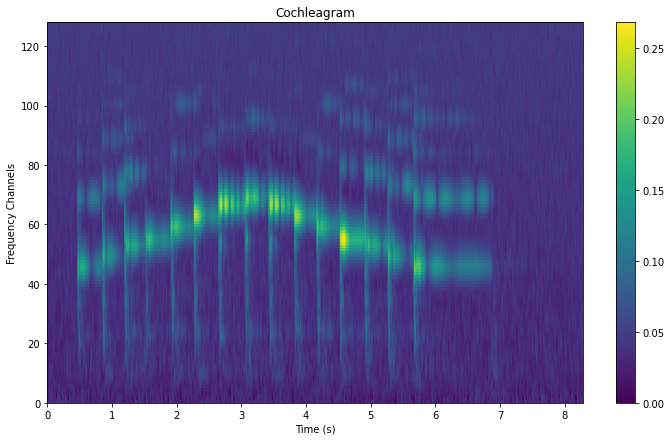

In [8]:
plot_cochleagram(cochleagram, sound.samplerate)

Windowing

In [9]:
print(f"Applying windowing to {sound.nsamples} samples:\n")

windows = apply_windowing(cochleagram, sound.samplerate)

print(f"Size: {WINDOW_SIZE_MS} ({windows.shape[2]} samples), "
      f"window shape: {windows.shape[1:]}\n"
      f"Overlap: {WINDOW_OVERLAP_MS} ({int(WINDOW_OVERLAP_MS * sound.samplerate)} samples)\n"
      f"Shape of the result: {windows.shape}")

Applying windowing to 397312 samples:

Size: 20. ms (960 samples), window shape: (128, 960)
Overlap: 10. ms (480 samples)
Shape of the result: (826, 128, 960)


Correlogram, cross-channel correlation, summary ACF

In [10]:
# Correlogram (ACF)
correlogram = compute_correlogram(windows)
print(f"Correlogram shape: {correlogram.shape}")

# Cross-channel correlation coefficients (Pearson's)
cccf = compute_cccf(windows)
print(f"Cross-channel correlation shape: {cccf.shape}")

# Summary ACF
sacf = compute_sacf(correlogram)
print(f"Summary autocorrelation shape: {sacf.shape}")

Correlogram shape: (826, 128, 960)
Cross-channel correlation shape: (826, 128)
Summary autocorrelation shape: (826, 960)


Harmonics of the fundamental frequency ~ max sum of SACF values

In [11]:
n_harmonics = 5
fundamental_lags, fundamental_freqs = find_fundamental_frequencies(sacf, sound.samplerate, n_harmonics)
print(f"Fundamental lags shape: {fundamental_lags.shape}")
print(f"Fundamental frequencies shape: {fundamental_freqs.shape}")

Fundamental lags shape: (826,)
Fundamental frequencies shape: (826,)


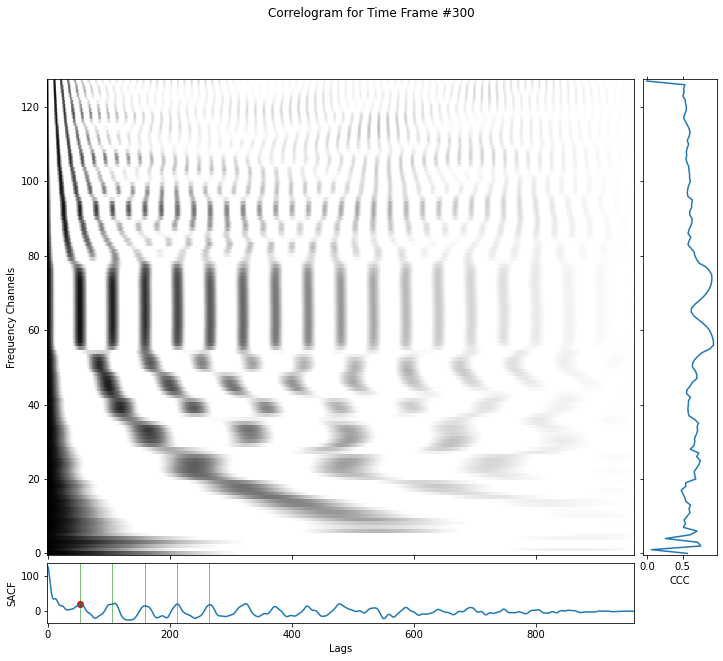

In [21]:
window_num = 300
plot_correlogram(correlogram, window_num, sound.samplerate, cccf=cccf, sacf=sacf,
                 show_f0=True, show_harmonics=True, n_harmonics=n_harmonics)

Experiments with segmentation

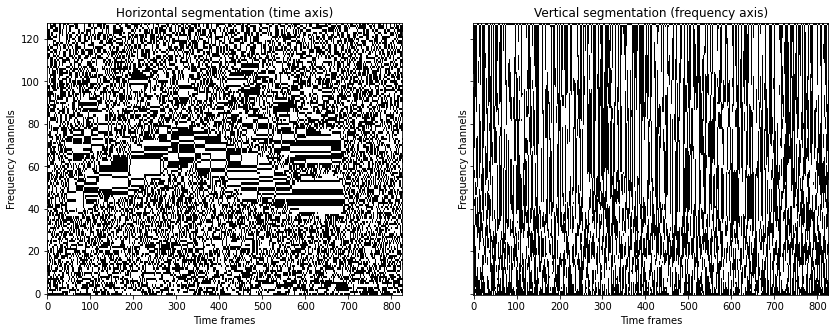

In [13]:
twcf_threshold = 0.8
cccf_threshold = 0.8
plot_segmentation(correlogram, twcf_threshold, cccf_threshold)

IBM estimate

In [14]:
energy_threshold = 0.05
agreement_threshold = 0.8

ibm, energy_values, agreement_ratios = compute_ibm(windows, fundamental_lags, sound.samplerate,
                                                   energy_threshold, agreement_threshold,
                                                   correlogram=correlogram, return_components=True)
print(f"IBM shape: {ibm.shape}")

IBM shape: (826, 128)


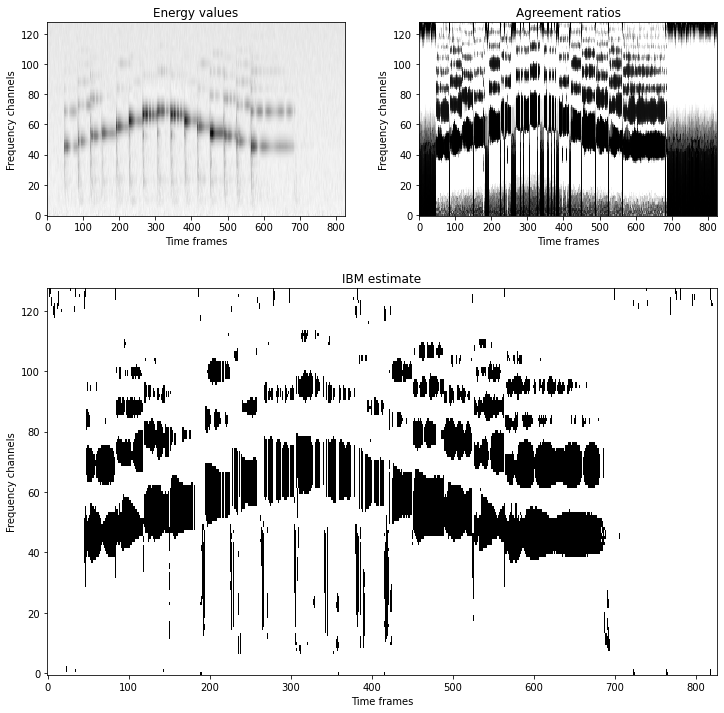

In [15]:
plot_ibm(ibm, energy_values, agreement_ratios)

Masked cochleagram

In [16]:
masked_cochleagram = apply_mask(cochleagram, ibm, sound.samplerate)
print(f"Masked cochleagram shape: {masked_cochleagram.shape}")

Masked cochleagram shape: (128, 397312)


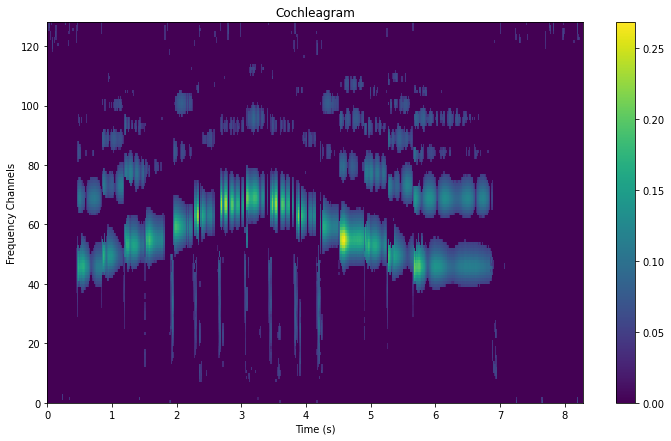

In [17]:
plot_cochleagram(masked_cochleagram, sound.samplerate)

Resynthesized sound

In [18]:
resynth = resynthesize_sound(masked_cochleagram, sound.samplerate)
save_sound(resynth, base_name + " Resynth." + extension)

To be able to play the resynthesized sound, add second channel

In [19]:
resynth = convert_to_binaural(resynth)

If Pygame is installed, you can uncomment the line below to play the resynthesized sound
WARNING! The sound may be very loud

In [20]:
# resynth.play()